# Impact of Apartment's storey on it's Price, Prediction of the Price for Apartment & Analysis of Venues in the Boroughs of the city Nur-Sultan.

In [1]:
import os
from scipy import stats
import pandas as pd
import numpy as np
import geocoder # import geocoder
import wikipedia
from wikitables import import_tables
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn import linear_model
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import json
import csv
import urlopen
from json import load
import urllib
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#

200


### A description of the problem and Discussion of the background 

In [2]:
############################################### Using URL of Krisha.KZ to scrap with soup
#response =  urllib.request.urlopen('https://krisha.kz/prodazha/kvartiry/nur-sultan/?das[live.rooms]=2')

i = 1
concatenated_body_str = ""
titles = []
texts = []
prices = []
boroughs_streets = []
while i < 31:
    str_i = str(i)
    response = urllib.request.urlopen('https://krisha.kz/prodazha/kvartiry/nur-sultan/?das[house.year][from]=1990&das[house.year][to]=2018&das[live.rooms]=2&das[live.square][from]=57&das[live.square][to]=62&page='+str_i)
    soup = BeautifulSoup(response,'html.parser')
    #concatenated_body_str = concatenated_body_str + str(soup.body)
    
    titles_lst = soup.findAll(class_='a-card__title')
    titles = titles + titles_lst
    prices_lst = soup.findAll(class_='a-card__price')
    prices = prices + prices_lst
    boroughs_streets_lst = soup.findAll(class_='a-card__subtitle')
    boroughs_streets = boroughs_streets + boroughs_streets_lst
    texts_lst = soup.findAll(class_='a-card__text-preview')
    texts = texts + texts_lst
    i = i + 1
#print(concatenated_body_str)

Astana(Nur-Sultan) is a capital of Kazakhstan. It is one of the biggest cities in Kazakhstan with population over than a million people. I decided to make this analysis due to request of my friend, who is real estate seller and lives in this city. Also the most interesting thing for him was an impact of floor number to the price of the flat. People who want to sell their flats quite often ask him to estimate the flat and suggest a reasonable price for the flat in order to publish the flat info and price in the advertisement. The price for the flat should be calculated very carefully, usually it shouldn't be too high and not too low. My friend has to consider lot's of similar supplies in the market and by taking into account all the characteristics and other factors related to the flat, he  has to produce a sensible price for it. The process of giving a price to the flat is very time consuming. Therefore I came up with an idea to help to my fiend to predict a price for the flat using some Data Science tools.Imported all necessary python libraries. Scraping data from a flat advertising agency's website using Beautiful soup

In [3]:

titles_list = [title.get_text() for title in titles]
ttl_list = []
for title in titles:
    ttl = title.get_text().split(",")
    if len(ttl) > 0:
        ttl_list.append(ttl[0].strip())
    else:
        ttl_list.append("NA")

boroughs_list = []
address_list = []
for borough in boroughs_streets:
    br_st = borough.get_text().replace("\n","").strip().split(",")
    if len(br_st) == 2:
        boroughs_list.append(br_st[0].strip())
        address_list.append(br_st[1].strip())
    else:
        boroughs_list.append("NA")
        address_list.append(br_st[0].strip())

texts_list = [text.get_text().strip() for text in texts]
prices_list = [int(price.get_text().replace("\n","").replace("\xa0","").strip().replace("〒","").replace("от ","").strip()) for price in prices]
sqms_list = [float(sqm.split(",")[1].replace("м²","").strip()) for sqm in titles_list]

years_list = []
for year in texts_list:
    if year.find("г.п.") != -1:
        years_list.append(int(year[year.find("г.п.")-5:year.find("г.п.")-1].strip()))
    elif year.find(" г") != -1:
        years_list.append(int("20" + year[year.find(" г")-3:year.find(" г")-1].strip()))

floors_list = []
hs_max_flr_list = []
for floor in titles_list:
    ttl_lst = floor.split(",")
    if len(ttl_lst) == 3:
        if floor.split(",")[2].find("/") != -1:
            floors_list.append(int(floor.split(",")[2][:floor.split(",")[2].find("/")].strip()))
            hs_max_flr_list.append(int(floor.split(",")[2][floor.split(",")[2].find("/")+1:floor.split(",")[2].find("/")+3].strip()))
        else:
            floors_list.append("NA")
            hs_max_flr_list.append("NA")
    elif len(ttl_lst) == 2 or len(ttl_lst) == 1:
        floors_list.append("NA")
        hs_max_flr_list.append("NA")


### A description of the data and how it will be used to solve the problem

To get data about flats in market, I did the following following research:

I have analyzed all the websites and online systems for selling and advertising flats. I have chosen the most popular web service for selling flats among customers in Kazakhstan. The website wasn't having any API, therefore I decided to scrape the data from it. I cleaned the data and retrieved all necessary information about each flat in the market of Nur-Sultan(Astana), though couldn't retrieve location data of each flat from the website. The data I scraped from the website was about building built year, borough, floor number, price, address and square meters. I made decision to analyse flats with very similar characteristics and chose only 2 - bedroom flats starting from 57 to 62 square meters. I picked flats built from 1990 year, I wanted to retrieve more data on tall buildings as much as possible, since houses built until 1990 weren't tall.

I used Foursquare API in order to retrieve number of venues in radius of 3000 metres from the center of each borough. I took the center coordinates of each borough from the 2GIS website. There are 4 main boroughs in Astana(Nur-Sultan), Esil is the biggest, Baikonyr, Almaty and Saryarka is the smallest borough in the city.

I couldn't find border coordinates for each borough, therefore I decided to draw a map of boroughs myself in the www.geojson.io, once I finished drawing the borders for the boroughs, the website automatically generated coordinates of the borders. I used the coordinates to draw a Choropleth map, which displayed number of venues in each borough.I Cleaned all the scraped data for a better processing and readability. Finally I designed a dictionary out of the cleaned data to create a dataframe.

In [4]:
data = {'Title':ttl_list,'Borough':boroughs_list,'Address':address_list,'Price':prices_list,'Built year':years_list,'Sqrms':sqms_list,'Flat Floor':floors_list,'Building max floor':hs_max_flr_list}
df = pd.DataFrame.from_dict(data)
df
#print(sqms_list)


,Title,Borough,Address,Price,Built year,Sqrms,Flat Floor,Building max floor
0,2-комнатная квартира,Есиль р-н,Сыганак 10/1,22200000,2007,58.5,2,12
1,2-комнатная квартира,Есиль р-н,Е16 2,20000000,2018,59.0,3,9
2,2-комнатная квартира,Есиль р-н,38-я улица 23,33000000,2018,62.0,4,7
3,2-комнатная квартира,Есиль р-н,Е 10 4,22000000,2015,58.0,1,9
4,2-комнатная квартира,Есиль р-н,Е-356,23800000,2018,60.0,7,8
...,...,...,...,...,...,...,...,...
597,2-комнатная квартира,Есиль р-н,Сауран 3/1,23800000,2012,61.0,2,12
598,2-комнатная квартира,Есиль р-н,Улы Дала,23299000,2017,60.0,2,8
599,2-комнатная квартира,Есиль р-н,Ханов Керея и Жанибека,23849000,2017,60.0,4,10
600,2-комнатная квартира,р-н Байконур,Отырар,19500000,2011,60.0,3,9


### Data cleaning and filtering

In order to avoid errors related with non numeric values, I removed all 'NA' values from the fields 'Flat Floor' and 'Borough', it left me with 533 records. Also, I picked the flats with price less than 100 million, since it's very unreal to find a flat that might cost more than 100 million tenge(Kazakhstan currency) for 2 bedroom flat with 57-62 squared meters, however sometimes you might find unique cases, though it might be just incorrectly entered data. All in all, I sorted the dataframe by 'Price' field in descending order. When printing first 10 records of the dataframe, it becomes obvious that the 10 out of 10 most expensive flats are in the 'Есиль р-н'('Esil' in latin) borough. The sorted dataframe also shows that, in the top ten expensive flats there is only one flat located on the floor higher than five and it is floor 18.   

In [5]:
df.drop(df[df['Flat Floor'] == 'NA'].index, inplace=True)
df.drop(df[df['Borough'] == 'NA'].index, inplace=True)
df.drop(df[df['Price'] > 100000000].index, inplace=True)
df.sort_values(by=['Price'], ascending = False, inplace=True )
df.reset_index(drop=True, inplace=True)

# Create the dictionary of borough ids
boroughs_ids ={'Алматы р-н' : 1, 'Сарыарка р-н' : 2, 'р-н Байконур' : 3, 'Есиль р-н' : 4} 

# Add a new column named 'Borough ID' 
df['Borough ID'] = df['Borough'].map(boroughs_ids)
df.head(10)

,Title,Borough,Address,Price,Built year,Sqrms,Flat Floor,Building max floor,Borough ID
0,2-комнатная квартира,Есиль р-н,Орынбор — проспект Мангилик Ел,35000000,2016,62.0,4,7,4
1,2-комнатная квартира,Есиль р-н,38-я улица 23,33000000,2018,62.0,4,7,4
2,2-комнатная квартира,Есиль р-н,Кабанбай Батыра 58Б — Улы Дала - Сауран,33000000,2017,59.0,2,8,4
3,2-комнатная квартира,Есиль р-н,проспект Кабанбай батыра 29/2 — Сыганак,33000000,2017,58.0,7,9,4
4,2-комнатная квартира,Есиль р-н,Керей Жанибек хандар 22 — Туркестан,32500000,2017,60.0,5,16,4
5,2-комнатная квартира,Есиль р-н,Кабанбай Батыра 58Б,32000000,2016,61.4,5,8,4
6,2-комнатная квартира,Есиль р-н,Кабанбай батыра 58 Б — Улы дала,32000000,2016,61.4,5,8,4
7,2-комнатная квартира,Есиль р-н,улица Сыганак 18/3 — Туркестан,32000000,2014,57.9,7,9,4
8,2-комнатная квартира,Есиль р-н,Сауран 3/1 — Сыганак,32000000,2007,59.8,5,12,4
9,2-комнатная квартира,Есиль р-н,Бектурова,32000000,2018,60.0,7,12,4


The top 10 cheapest flats are illustrated in the dataframe below. All the cheapest flats are mainly located in two boroughs, 'Алматы р-н'('Almaty' in Latin) and 'Сарыарка р-н'('Saryarka' in Latin). There are five flats in 'Almaty' and two flats in each 'Saryarka' and 'Baikonyr' boroughs. 

In [6]:
df.tail(10)

,Title,Borough,Address,Price,Built year,Sqrms,Flat Floor,Building max floor,Borough ID
541,2-комнатная квартира,Алматы р-н,Кордай,14550000,2018,57.0,2,14,1
542,2-комнатная квартира,Алматы р-н,Кордай,14550000,2012,57.0,2,14,1
543,2-комнатная квартира,Сарыарка р-н,189 улица 12/1,14500000,2012,60.9,9,9,2
544,2-комнатная квартира,Сарыарка р-н,189 12/1,14500000,2013,60.9,9,10,2
545,2-комнатная квартира,Сарыарка р-н,189-ая улица,14500000,2013,60.0,9,9,2
546,2-комнатная квартира,Алматы р-н,Жабаева — Иманак,14500000,2010,60.0,1,5,1
547,2-комнатная квартира,Алматы р-н,Жабаева 12/2,14500000,2012,57.1,1,6,1
548,2-комнатная квартира,Сарыарка р-н,189 улица 12/1,14300000,2013,60.9,9,9,2
549,2-комнатная квартира,Сарыарка р-н,189 улица 12/1,14300000,2013,61.0,9,10,2
550,2-комнатная квартира,Сарыарка р-н,проспект Нургисы Тлендиева,13500000,2016,58.0,5,6,2


### Plotting relationship between 'Price' and 'Floor number of flat'

In order to see the whole picture and relation of the data I collected, I created a scatter plot from the dataframe using fields: 'Flat Floor' and 'Price'. I used these fields, cause the 'Flat floor number' was the most interesting characteristic, for my client. The scatter plot below doesn't illustrate neither positive nor negative correlation.

Text(0, 0.5, 'Price')

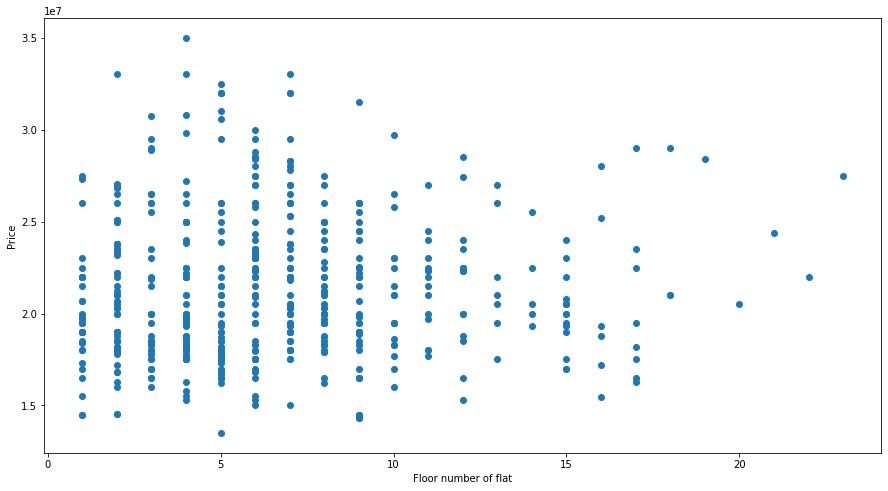

In [7]:
plt.figure(figsize=(15,8))
plt.scatter(df['Flat Floor'], df['Price'])
plt.xlabel('Floor number of flat')
plt.ylabel('Price')

### Applying Linear and Polynomial models

I decided to check whether my data fits to Linear or Polynomial regressions. The two lines below showing that there is only 9% of fitting for Linear Regression and only 2% for Polynomial Regression. It means that I can't predict prices for other flats, cause percentage value in both cases is very low. Hence, my data doesn't fit to both Linear and Polynomial regressions. 

In [8]:
x = list(df['Flat Floor'])
y = list(df['Price'])
############################################## Linear Regression fitting

slope, intercept, r, p, std_err = stats.linregress(x, y)

############################################## Polynomial Regression fitting

mymodel = np.poly1d(np.polyfit(x, y, 3))

print("Linear Regression fitting %: ", r)
print("Polynomial Regression fitting %: ", r2_score(y, mymodel(x)))

#********************************************* The result below shows bad fit for both Linear and Polynomial regressions

Linear Regression fitting %:  0.04489627158919115
Polynomial Regression fitting %:  0.01312702398835286


### Predicting a price for a new flat, applying Multiple regression

Since the Linear and Plynomial regressions didn't fit to my dataset, I made decision to apply Multiple regression for predicting price of a flat. Although, I used not only 'Flat floor', but also 'Borough ID', 'Square meters' and 'Building built year' characterstics to predict the price. To test the prediction model, I passed the following values, 'Flat floor' = 6, 'Borough ID' = 2 (Saryarka), 'Square meters' = 61 and 'Building built year' = 2016. The predicted price seemed quite reasonable.

In [9]:
# ******************************************** Passing multiple values for X, in order to predict a flat price
X = df[['Flat Floor', 'Borough ID', 'Sqrms', 'Built year']]
y = df['Price']

regr = linear_model.LinearRegression()
regr.fit(X, y)

#predict the Price of a flat where the Flat floor is 6, Borough ID is 2, Sqrms is 61 and the Built year is 2015:
predictedPrice = regr.predict([[6, 2, 61, 2016]])

print("Predicted price of a flat is: ", predictedPrice[0])
#********************************************** The result below is a predicted price of a flat

Predicted price of a flat is:  21408785.233909965


### KMeans clustering

In order to divide the data into different clusters I decided to use KMeans clustering. In order to decide number of clusters needed to cluster my data, I applied 'Elbow' method. The first step was calculation of Sum of Squared Error in order to implement the 'Elbow' method. By means of plotting relation of K to SSE we can see an 'elbow', the line breaks when K is 2 and 3, we now can see that number of clusters should be 2 or 3. I decided to stick with 3 for my data.

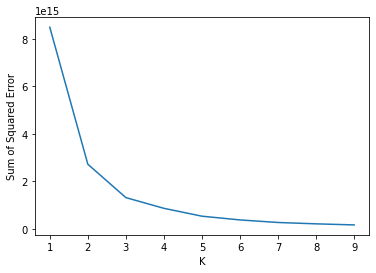

In [10]:
k_range = range(1,10)
sse = []
for k in k_range:
    km = KMeans(n_clusters = k)
    km.fit(df[['Flat Floor','Price']])
    sse.append(km.inertia_)
#sse

plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(k_range,sse)

The next step was applying KMeans object with 3 clusters. Afterwards, I did fitting and predicting clusters for 'Flat floor' and 'Price' vaues in the dataframe. The result of clustering the dataframe can be seen below.

In [11]:
km = KMeans(n_clusters=3)
#km
y_predicted = km.fit_predict(df[['Flat Floor', 'Price']])
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

I created a new column 'cluster' and added all the predicted clusters in the dataframe. All the flats became clusterized now. The dataframe below demonstrates the result.

In [12]:
df['cluster'] = y_predicted
df

,Title,Borough,Address,Price,Built year,Sqrms,Flat Floor,Building max floor,Borough ID,cluster
0,2-комнатная квартира,Есиль р-н,Орынбор — проспект Мангилик Ел,35000000,2016,62.0,4,7,4,1
1,2-комнатная квартира,Есиль р-н,38-я улица 23,33000000,2018,62.0,4,7,4,1
2,2-комнатная квартира,Есиль р-н,Кабанбай Батыра 58Б — Улы Дала - Сауран,33000000,2017,59.0,2,8,4,1
3,2-комнатная квартира,Есиль р-н,проспект Кабанбай батыра 29/2 — Сыганак,33000000,2017,58.0,7,9,4,1
4,2-комнатная квартира,Есиль р-н,Керей Жанибек хандар 22 — Туркестан,32500000,2017,60.0,5,16,4,1
...,...,...,...,...,...,...,...,...,...,...
546,2-комнатная квартира,Алматы р-н,Жабаева — Иманак,14500000,2010,60.0,1,5,1,2
547,2-комнатная квартира,Алматы р-н,Жабаева 12/2,14500000,2012,57.1,1,6,1,2
548,2-комнатная квартира,Сарыарка р-н,189 улица 12/1,14300000,2013,60.9,9,9,2,2
549,2-комнатная квартира,Сарыарка р-н,189 улица 12/1,14300000,2013,61.0,9,10,2,2


### Plotting three clusters on the Scatter plot

I created three data frames and assigned them three clusters from 0 to 2 inclusively. Afterwards, I added the fields 'Flat floor' and 'Price' of all the three dataframes in the scatter plot, also I assigned three different colors for each cluster, namely yellow, green and blue. The three red crosses in the scatter plot denote centroids of the clusters. Finally, I added X,Y labels with appropriate text and gave a title for the scatter plot.

The scatter plot illustrates that the majority of the most expensive flats are located below 7th floor. In general, it can be inferenced that the lower the floor the higher the price for the flat. Nevertheless, this is not the only weighty factor impacting on the price of the flat, there are lot's of other reasons.

There is only one outlier flat on the 18th floor for 35 million tenge. It can be treated as a unique case, which is included in the top ten the most expensive flats.

Text(0.5, 1.0, 'Relation of Apartment`s storey to the price of flat')

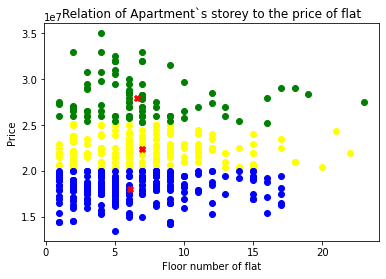

In [13]:
# ********************* Centroids of the clusters
km.cluster_centers_
# *********************
df1 = df[df['cluster'] == 0]
df2 = df[df['cluster'] == 1]
df3 = df[df['cluster'] == 2]

plt.scatter(df1['Flat Floor'], df1['Price'], color='yellow')
plt.scatter(df2['Flat Floor'], df2['Price'], color='green')
plt.scatter(df3['Flat Floor'], df3['Price'], color='blue')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='red',marker='X',label='centroid')

plt.xlabel('Floor number of flat')
plt.ylabel('Price')
#plt.ylim(10000000,40000000)
plt.title('Relation of Apartment`s storey to the price of flat')
#plt.legend(['10-17 m.','17-21 m.','21-24 m.','24-29 m.','29-42 m.'])

### Retrieving location data using Foursquare API

I retrieved venues data for each borough using Foursquare API. I used other GIS services to find locations for each borough. Afterwards, I applied 'explore' query with radius equal to 3000 meters from the center of each borough. The response was a JSON file, which required parsing the file and retrieving venue and location data. All in all, I created a dataframe from a dictionary with borough names, venues, category, distance and locations.

The table below shows only 6 venues for 'Алматы р-н'('Almaty' in Latin), 8 for 'Сарыарка р-н'('Saryarka' in Latin), 30 for 'Есиль р-н'('Esil' in Latin) and 3 in 'р-н Байконур'('Baikonyr' in Latin) boroughs.

One of the reasons for location of the cheapest flats in the boroughs, such as 'Алматы р-н'('Almaty' in Latin) and 'Сарыарка р-н'('Saryarka' in Latin) might be in lack of venues nearby.

In [14]:
# ******************************************* Scraping from 
CLIENT_ID = 'write your id'
CLIENT_SECRET = 'write your secret'
#QUERY = 'cafe'
BOROUGHS = ['Алматы р-н','Сарыарка р-н','р-н Байконур','Есиль р-н']
BOROUGHS_LL = ['51.144957,71.589907','51.1892,71.3562','51.2257,71.4495', '51.0897,71.3781']
# ******************************************* Nur-Sultan(Astana) bounds coordinates list
astana_bound_coords = [[50.949137,71.25763],[51.015405,71.15911],[51.259035,71.127413],[51.306666,71.33122],[51.331666,71.641526],[51.378815,71.718671],[51.217734,71.842987],[51.02963,71.87991],[50.971068,71.86563],[50.928205,71.609524],[50.949137,71.25763]]
#LL = '51.1, 71.4' #Astana
#LL = '40.7243,-74.0018' # New Yourk

V = '20200520'
#endpoint = 'search'
endpoint = 'explore'

boroughs_data = []
for i in range(len(BOROUGHS_LL)):
    url = 'https://api.foursquare.com/v2/venues/'+endpoint+''

    params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v=V,
    ll=BOROUGHS_LL[i],
    #ll=LL,
    intent = 'checkin',
    radius= 3000,
    #query=QUERY[i],
    #limit=1
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    boroughs_data.append(data)


In [15]:
# ************************************************* This is for explore query of Foursquare 

all_boroughs = []
for it in boroughs_data:
    borough_venues = []
    for item in it['response']['groups']:
        borough_venues.append(item['items'])
        #print(item['items'])
    all_boroughs.append(borough_venues)
    
# ************************************************* 

categories_list = []
distances_list = []
ven_names_list = []
borough_names_list = []
location_lat_list = []
location_lng_list = []

for i in range(len(all_boroughs)):

    for item in all_boroughs[i][0]:
        categories_list.append( item["venue"]["categories"][0]["name"])
        distances_list.append( item["venue"]["location"]["distance"])
        location_lat_list.append(item["venue"]["location"]["lat"])
        location_lng_list.append(item["venue"]["location"]["lng"])
        ven_names_list.append( item["venue"]["name"])
        borough_names_list.append(BOROUGHS[i])

In [16]:
data = {'Borough': borough_names_list, 'Venue': ven_names_list, 'Venue category': categories_list, 'Distance from borough center(m)': distances_list, 'Latitude':location_lat_list, 'Longitude':location_lng_list}
df_location = pd.DataFrame.from_dict(data)
df_location

,Borough,Venue,Venue category,Distance from borough center(m),Latitude,Longitude
0,Алматы р-н,KEN MART,Shopping Mall,1580,51.135385,71.573187
1,Алматы р-н,Серуен,Spa,1443,51.132008,71.590995
2,Алматы р-н,Golf Club,Golf Course,2826,51.121297,71.575219
3,Алматы р-н,Конно-спортивный Центр Кулагер,Stables,2929,51.119511,71.600626
4,Сарыарка р-н,Хива,Middle Eastern Restaurant,2847,51.195362,71.395820
5,Сарыарка р-н,Коктал,Asian Restaurant,420,51.185654,71.354110
6,Сарыарка р-н,ТЦ Рахмет 2,Shopping Mall,1830,51.179744,71.377654
7,Сарыарка р-н,Астыкжан,Grocery Store,2125,51.182244,71.384574
8,Сарыарка р-н,Рынок Саянур,Market,825,51.189626,71.344391
9,Сарыарка р-н,Приют бодливой козы,Bar,2859,51.195249,71.396038


In [17]:
BOROUGHS
ven_num = []

for i in range(len(all_boroughs)):
    ven_num.append(len(all_boroughs[i][0]))

ven_num_data = {'Borough': ['Almaty','Saryarka','Baikonyr','Esil'], 'Venues':ven_num}
df_venue_data = pd.DataFrame.from_dict(ven_num_data)
df_venue_data

,Borough,Venues
0,Almaty,4
1,Saryarka,8
2,Baikonyr,2
3,Esil,29


### Creating a Choropleth map

Creating a map of Astana(Nur-Sultan) city with it's boroughs and venues using Folium library required lot's of location data, such as latitude and longitude. The markers for boroughs centers and for venues in four different boroughs are colored with four different colors. The borough markers have 'star' icon, while venue markers have 'i' icon.

In order to create a Choropleth map I needed latitudes and longitudes of borders for each borough. I decided to draw the borders using www.geojson.io service, it has functions that can generate coordinates for the drawn polygons. I colored markers in four different colors, red, blue, green and purple.

The Choropleth map below shows, that the most number of close to the borough center venues are located in the 'Esil' borough. In the other three boroughs number of the venues is below ten. A high number of venues in the 'Esil' borough might be one of the reasons for a very high prices for flats in comparison with other boroughs.     

In [18]:
astana_map = folium.Map(
    #location = [43.238949, 76.889709], # Kazakhstan
    location = [51.169392, 71.449074], # Astana(Nur-Sultan)
    zoom_start = 11,
    #tiles = 'Stamen Terrain'
    #tiles = 'Mapbox Bright'
    #tiles = 'Stamen toner'
)

################################################################# Markers

ttip = 'Click to see more info!'

folium.Marker(
    [51.144957,71.589907],
    popup = '<strong>Almaty</strong>',
    tooltip = ttip,
    icon=folium.Icon(color='red',icon='star')).add_to(astana_map)

folium.Marker(
    [51.1892,71.3562],
    popup = '<strong>Saryarka</strong>',
    tooltip = ttip,
    icon=folium.Icon(color='green',icon='star')).add_to(astana_map)

folium.Marker(
    [51.2257,71.4495],
    popup = '<strong>Baikonyr</strong>',
    tooltip = ttip,
    icon=folium.Icon(color='blue',icon='star')).add_to(astana_map)

folium.Marker(
    [51.0897,71.3781],
    popup = '<strong>Esil</strong>',
    tooltip = ttip,
    icon=folium.Icon(color='purple',icon='star')).add_to(astana_map)

################################################################# Circle markers
"""
folium.CircleMarker(
    location=[51.144957,71.589907],
    radius=100,
    popup='This is Almaty borough',
    color='red',
    fill=True,
    fill_color='red').add_to(astana_map)
folium.CircleMarker(
    location=[51.1892,71.3562],
    radius=80,
    popup='This is Saryarka borough',
    color='green',
    fill=True,
    fill_color='green').add_to(astana_map)
folium.CircleMarker(
    location=[51.1677,71.4495],
    radius=120,
    popup='This is Baikonyr borough',
    color='blue',
    fill=True,
    fill_color='blue').add_to(astana_map)
folium.CircleMarker(
    location=[51.0897,71.3781],
    radius=150,
    popup='This is Esil borough',
    color='purple',
    fill=True,
    fill_color='purple').add_to(astana_map)
"""
for i in range(len(all_boroughs)):

    for item in all_boroughs[i][0]:
        if i == 0:
            col = 'red'
        elif i == 1:
            col = 'green'
        elif i == 2:
            col = 'blue'
        else:
            col = 'purple'
            
        folium.Marker(
        [item["venue"]["location"]["lat"],item["venue"]["location"]["lng"]],
        popup = '<strong>'+item["venue"]["name"]+'</strong>',
        tooltip = ttip,
        icon=folium.Icon(color=col)).add_to(astana_map)

#astana_map.save('C:/Users/asset/Dropbox/Data_Science/Coursera_Capstone2/astana_map.html')
#astana_map


In [19]:
boroughs = os.path.join('C:/Users/asset/Dropbox/Data_Science/Coursera_Capstone2/astana_map.geojson')
#boroughs = r'C:/Users/asset/Dropbox/Data_Science/Coursera_Capstone2/astana_boroughs_overlay.json'

In [20]:

choropleth = folium.Choropleth(
    geo_data = boroughs,
    name = 'Choropleth',
    data = df_venue_data,
    columns = ['Borough','Venues'],
    key_on = 'feature.id',
    fill_color = 'YlGn',
    line_weight=2,
    fill_opacity = 0.7,
    line_opacity = 0.2,
    #nan_fill_color='purple',
    #nan_fill_opacity=0.4,
    #bins=[3, 4, 9, 11],
    highlight=True,
    legend_name = 'Number of venues in boroughs'
    #show=False,
).add_to(astana_map)

#print(type(choropleth.geojson))
#print(type(choropleth.color_scale))

folium.LayerControl().add_to(astana_map)
astana_map



#folium.GeoJson(boroughs, name='Astana boroughs').add_to(astana_map)
#astana_map

### Conclusion

In this study, I analyzed the real estate market of the city Astana(Nur-Sultan) in Kazakhstan. For a better and thorough analysis I used data science tools and methods. My analysis covered relationship between price of the flat and floor number of the flat. In my analysis I collected data on flats with very similar characteristics, since my main aim was to find the flat floor numbers of the top most expensive flats in the city. The analysis revealed that the 90 % of the top ten the most expensive flats are located below 5th floor. Also I retrieved location data for each borough, in order to see if number of venues has an impact on the price of the flat. The hypothesis was true only for the biggest borough of the city, which is 'Esil'. The other boroughs have numbers close to each other, and they all are below 10. I also used predicting models, to predict prices for a new flats, the model that was applied in my research was a Multiple regression. This research can help for people, who want to sell flats or work in real estate market, but not sure about what price they want for their flat. Also it might be helpful for those who want to buy a flat.